
The R0 is between 2 and 6, meaning each infected person infects 2–6 others, which can cause the number of infected to double every few days.

In [ ]:

# https://informationisbeautiful.net/visualizations/covid-19-coronavirus-infographic-datapack/
# https://docs.google.com/spreadsheets/d/1g_YxmDfQx7aOU2DKzNZo9b-NTk62Bju6X3z6OuCa6gw/edit#gid=515684451

In [2]:

import sys

command_str = '{sys.executable} -m pip install --upgrade tweepy'.format(sys=sys)
print(command_str)
!{command_str}

C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade tweepy


In [1]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [2]:

%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
#pandemic_df = s.load_object('pandemic_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

%pprint
dir()

D:\Documents\Repositories\notebooks\covid19\ipynb\Corona Virus Curve Fitting.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
Pretty printing has been turned OFF


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '__warningregistry__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'nx', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_files_ending_wit

In [3]:

column_description_dict = s.load_object('column_description_dict')
def get_column_description(column_name):
    if column_name in column_description_dict:
        column_description = column_description_dict[column_name]
    else:
        column_description = re.sub('^pf_', 'Personal Freedom:_', str(column_name), 1)
        column_description = re.sub('^hf_', 'Human Freedom:_', str(column_description), 1)
        column_description = re.sub('^ef_', 'Economic Freedom:_', str(column_description), 1)
        column_list = column_description.split('_')
        descr_list = []
        for word in column_list:
            descr_list.append(word[0].upper()+word[1:])
        column_description = ' '.join(descr_list)
        column_description_dict[column_name] = column_description
        s.store_objects(column_description_dict=column_description_dict)
    
    return column_description

In [ ]:

!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(notebook_path))}"

In [ ]:

for file_name in os.listdir(s.saves_pickle_folder):
    if file_name.endswith('_df.pickle'):
        df_name = file_name.split('.')[0]
        print("{} = s.load_object('{}')".format(df_name, df_name))
        print("{}".format(df_name))


---
# Create the Curve Fitter

In [4]:

def get_doubling_days(count_yesterday, count_today):
    growth_rate = (count_today-count_yesterday)/count_today
    doubling_time = math.log(2)/growth_rate
    
    return doubling_time

In [5]:

def get_lb_ub(p0):
    if p0 < 0:
        uba = math.copysign(abs(p0)/10, p0)
        lba = math.copysign(abs(p0)*10, p0)
    else:
        lba = math.copysign(abs(p0)/10, p0)
        uba = math.copysign(abs(p0)*10, p0)
    
    return lba, uba

In [9]:

def format_the_data(column_name, min_x=0):
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    mask_series = (tracking_df[column_name] >= min_x)
    df = tracking_df[mask_series][columns_list].dropna(axis='index', how='any')
    
    return df

In [7]:

def get_average_doubling(confirmation_data):
    doubling_time_list = []
    for i, confirms in enumerate(confirmation_data):
        if i > 0:
            doubling_time = get_doubling_days(confirmation_data[i-1], confirmation_data[i])
            doubling_time_list.append(doubling_time)
    average_doubling_time = np.array(doubling_time_list).mean()
    
    return average_doubling_time

In [8]:

tracking_df = s.load_object('usa_df')
tracking_df.set_index('Date', drop=True, inplace=True)
columns_list = ['Confirmed_New', 'Confirmed_Cumulative', 'Deaths_New', 'Deaths_Cumulative']
tracking_df[columns_list].tail()

,Confirmed_New,Confirmed_Cumulative,Deaths_New,Deaths_Cumulative
Date,,,,
2020-04-04,34068.0,307876.0,1352.0,8359.0
2020-04-05,25717.0,333593.0,1175.0,9534.0
2020-04-06,29362.0,362955.0,1212.0,10746.0
2020-04-07,30752.0,393707.0,1928.0,12674.0
2020-04-08,NaN,NaN,NaN,NaN



---
## Geometric Brownian motion

In [130]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

method = ['lm', 'trf', 'dogbox'][1]
def fit_gbm_curve(column_name='Deaths_Cumulative',
                  lba=1e-09, lbb=-49, lbc=0.1,
                  uba=0.1, ubb=-41, ubc=10,
                  p0a=0.05, p0b=-46, p0c=1,
                  min_x=None, after_day=None):
    
    # Format the data
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    mask_series = [True] * tracking_df.shape[0]
    if after_day is not None:
        date_obj = datetime(year=2020, month=3, day=after_day)
        mask_series = mask_series & (tracking_df.index >= pd.Timestamp(date_obj))
    if min_x is not None:
        mask_series = mask_series & (tracking_df[column_name] >= min_x)
    df = tracking_df[mask_series][columns_list]
    if 'cumul' in column_name.lower():
        df.interpolate(axis='index', limit_area='inside', inplace=True)
    df.dropna(axis='index', how='any', inplace=True)
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def func(x, mu, sigma, dt):
        
        return np.exp((mu - sigma**2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(1, df.shape[0])).T)
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc],
                    [uba, ubb, ubc])
    p0_array = np.array([p0a, p0b, p0c])
    popt, pcov = curve_fit(func, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Plot the cumulative data
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, autoscale_on=True)
    ax.set_yscale('log')
    country_name = column_name.split('_')[-1]
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))
    
    # Plot the fitted curve
    def get_cumulative_confirmations(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #print('e^({} + {}*{}) + {}'.format(popt[0], popt[1], dayofyear, popt[2]))
        
        return np.exp(popt[0] + popt[1]*dayofyear) + popt[2]
    label_str = 'fit: cc = e^(%3.1f + %3.1f*doy) + %3.1f' % tuple(popt)
    line_2d_obj = plt.plot(dayofyear_data, get_cumulative_confirmations(dayofyear_data), 'r-', label=label_str)
    
    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{} {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()
    
    # Get the doubling time
    average_doubling_time = get_average_doubling(confirmation_data)
    
    return popt, average_doubling_time, get_cumulative_confirmations


---
## Exponential Curves

In [130]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

method = ['lm', 'trf', 'dogbox'][1]
def fit_exp_curve(column_name='Deaths_Cumulative',
                  lba=1e-09, lbb=-49, lbc=0.1,
                  uba=0.1, ubb=-41, ubc=10,
                  p0a=0.05, p0b=-46, p0c=1,
                  min_x=None, after_day=None):
    
    # Format the data
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    mask_series = [True] * tracking_df.shape[0]
    if after_day is not None:
        date_obj = datetime(year=2020, month=3, day=after_day)
        mask_series = mask_series & (tracking_df.index >= pd.Timestamp(date_obj))
    if min_x is not None:
        mask_series = mask_series & (tracking_df[column_name] >= min_x)
    df = tracking_df[mask_series][columns_list]
    if 'cumul' in column_name.lower():
        df.interpolate(axis='index', limit_area='inside', inplace=True)
    df.dropna(axis='index', how='any', inplace=True)
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def func(x, a, b, c):
        
        return np.exp(a + b*x) + c
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc],
                    [uba, ubb, ubc])
    p0_array = np.array([p0a, p0b, p0c])
    popt, pcov = curve_fit(func, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Plot the cumulative data
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, autoscale_on=True)
    ax.set_yscale('log')
    country_name = column_name.split('_')[-1]
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))
    
    # Plot the fitted curve
    def get_cumulative_confirmations(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #print('e^({} + {}*{}) + {}'.format(popt[0], popt[1], dayofyear, popt[2]))
        
        return np.exp(popt[0] + popt[1]*dayofyear) + popt[2]
    label_str = 'fit: cc = e^(%3.1f + %3.1f*doy) + %3.1f' % tuple(popt)
    line_2d_obj = plt.plot(dayofyear_data, get_cumulative_confirmations(dayofyear_data), 'r-', label=label_str)
    
    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{} {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()
    
    # Get the doubling time
    average_doubling_time = get_average_doubling(confirmation_data)
    
    return popt, average_doubling_time, get_cumulative_confirmations


---
## Cumulative Confirmations Exponential Curve

In [189]:

from datetime import timedelta

def get_cc(doy, column_name='Confirmed_Cumulative'):
    mask_series = (tracking_df.index == pd.Timestamp(datetime(2020, 1, 1) + timedelta(days=doy-1)))
    series = tracking_df[mask_series][column_name]
    
    return series.tolist()[0]

In [190]:

def get_a_b(doy1, doy2, column_name='Confirmed_Cumulative'):
    b = (np.log(get_cc(doy2, column_name)) - np.log(get_cc(doy1, column_name)))/(doy2-doy1)
    #a = np.log(get_cc(doy2, column_name)) - doy2*b
    a = np.log(get_cc(doy1, column_name)) - doy1*b
    
    return a, b

In [195]:

def snake_exp(column_name):
    
    # Format the data
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    mask_series = [True] * tracking_df.shape[0]
    df = tracking_df[mask_series][columns_list]
    if 'cumul' in column_name.lower():
        df.interpolate(axis='index', limit_area='inside', inplace=True)
    df.dropna(axis='index', how='any', inplace=True)

    # Plot the cumulative data
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, autoscale_on=True)
    ax.set_yscale('log')
    country_name = column_name.split('_')[-1]
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))

    # Plot the exponential curve
    a, b = get_a_b(61, 89, column_name=column_name)
    exponential_data = np.array(object=[np.exp(a+b*ts.dayofyear) for ts in df.index])
    label_str = 'f(x) = epx({}+{}*doy)'.format(round(a, 1), round(b, 1))
    line_2d_obj = plt.plot(dayofyear_data, exponential_data, 'r-', label=label_str)

    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{}, {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()

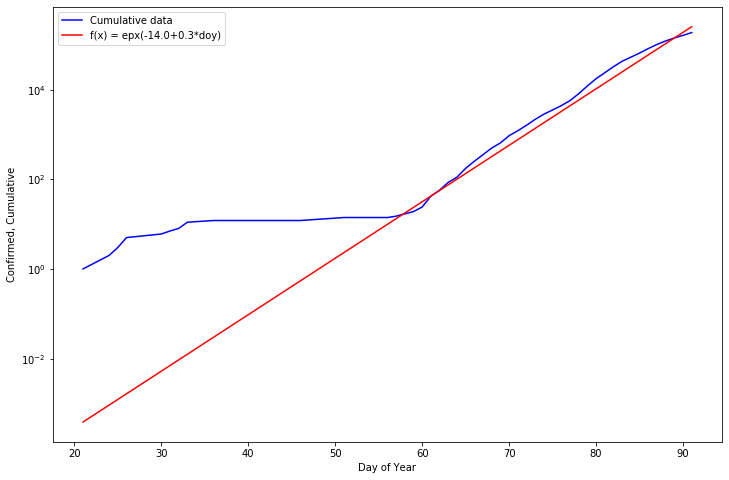

In [196]:

column_name = 'Confirmed_Cumulative'
snake_exp(column_name=column_name)

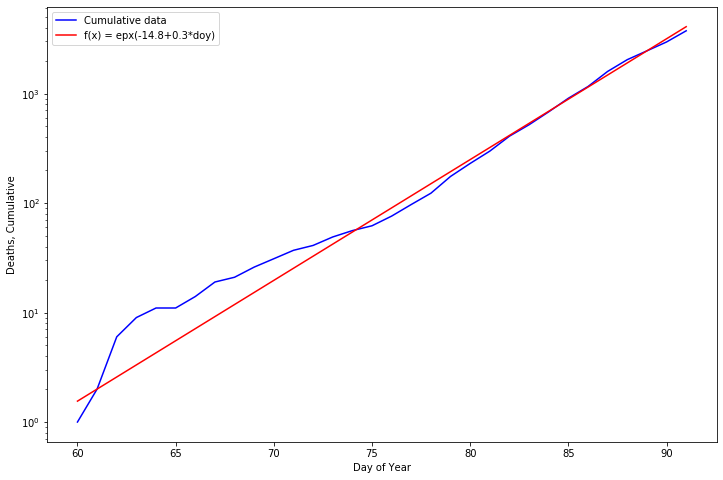

In [197]:

column_name = 'Deaths_Cumulative'
snake_exp(column_name=column_name)

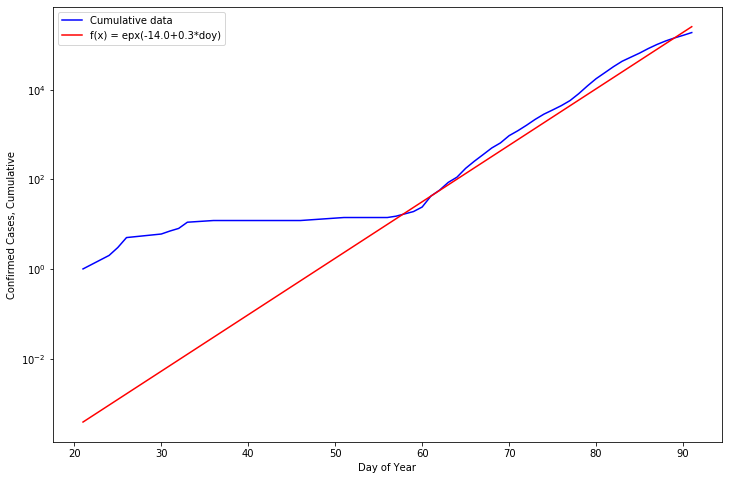

In [191]:

# Plot the deaths data
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, autoscale_on=True)
ax.set_yscale('log')
country_name = column_name.split('_')[-1]
dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))

# Plot the exponential curve
a, b = get_a_b(61, 89)
exponential_data = np.array(object=[np.exp(a+b*ts.dayofyear) for ts in df.index])
label_str = 'f(x) = epx({}+{}*doy)'.format(round(a, 1), round(b, 1))
line_2d_obj = plt.plot(dayofyear_data, exponential_data, 'r-', label=label_str)

# Label the graph
plt.xlabel('Day of Year')
label_list = column_name.split('_')
plt.ylabel('{} Cases, {}'.format(label_list[0], label_list[1]))
legend_obj = plt.legend()

In [183]:


# Get the doubling time
get_average_doubling(exponential_data)

2.4923290471754433

In [185]:

from datetime import datetime

# f(x)=epx(-13190.82+0.300x) ; R2=0.989
# f(x)=exp(-13416.45+0.306x) ; R2=0.986
lba = a*10
uba = a/10
p0a = a

lbb = b/10
ubb = b*10
p0b = b

lbc = -10
ubc = 10
p0c = 0

first_time = True
column_name = 'Confirmed_Cumulative'

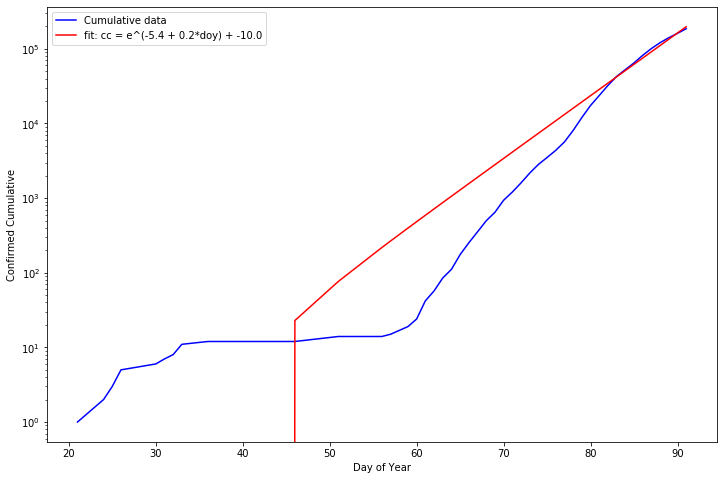

In [186]:

if first_time:
    first_time = False
else:
    p0a = popt[0]
    lba, uba = get_lb_ub(p0a)
    p0b = popt[1]
    lbb, ubb = get_lb_ub(p0b)
    p0c = popt[2]
    lbc, ubc = get_lb_ub(p0c)
try:
    popt, doubling_days, get_results = fit_exp_curve(column_name, lba=lba, lbb=lbb, lbc=lbc,
                                                     uba=uba, ubb=ubb, ubc=ubc,
                                                     p0a=p0a, p0b=p0b, p0c=p0c,
                                                     min_x=1)
except Exception as e:
    message = str(e).strip()
    print(message)

In [187]:

print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))
print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))
print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))


lba = -139.50819406836965
uba = -1.3950819406836965
p0a = -13.950819406836965

lbb = 0.028997522992000545
ubb = 2.8997522992000544
p0b = 0.28997522992000546

lbc = -10
ubc = 10
p0c = 0


In [41]:

date_obj = datetime(year=2020, month=4, day=1)
dayofyear = pd.Timestamp(date_obj).dayofyear
new_deaths = int(get_results(dayofyear))
print('The US will have {:,} cumulative confirmations on {}.'.format(new_deaths, date_obj.strftime('%b %d, %Y')))

The US will have 190,259 cumulative confirmations on Apr 01, 2020.



---
# Spike Curves

In [125]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

method = ['lm', 'trf', 'dogbox'][1]
def fit_spike_curve(column_name='Deaths_New',
                    lba=1e-09, lbb=-49, lbc=3.8,
                    uba=0.1, ubb=-41, ubc=8.3,
                    p0a=0.05, p0b=-46, p0c=3.9,
                    min_x=1):
    
    # Format the data
    df = format_the_data(column_name, min_x)
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def func(x, a, b, c):

        return a*np.exp(-np.abs(b-x)) + a*np.exp(-np.abs(-b-x)) + c
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc],
                    [uba, ubb, ubc])
    p0_array = np.array([p0a, p0b, p0c])
    popt, pcov = curve_fit(func, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Plot the cumulative data
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    label_str = get_column_description(column_name)
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='data: {}'.format(label_str))
    
    # Plot the fitted curve
    def get_spike_curve(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        fitted_str = '{}*np.exp(-np.abs({}-{})) + {}*np.exp(-np.abs(-{}-{})) + {}'
        print(fitted_str.format(popt[0], popt[1], dayofyear, popt[0], popt[1], dayofyear, popt[2]))
        
        return popt[0]*np.exp(-np.abs(popt[1]-dayofyear)) + popt[0]*np.exp(-np.abs(-popt[1]-dayofyear)) + popt[2]
    fitted_str = 'fit: cc = {}*e^(-|{}-doy|) + {}*e^(-|-{}-doy|) + {}'
    label_str = fitted_str.format(round(popt[0], 1), round(popt[1], 1), round(popt[0], 1), round(popt[1], 1), round(popt[2], 1))
    line_2d_obj = plt.plot(dayofyear_data, get_spike_curve(dayofyear_data), 'r-', label=label_str)
    
    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{} {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()
    
    # Get the doubling time
    average_doubling_time = get_average_doubling(confirmation_data)
    
    return popt, average_doubling_time, get_spike_curve


## New Deaths Spike Curve

In [126]:

lba = 427.01555905769817
uba = 42701.55590576982
p0a = 4270.155590576982

lbb = 88.06176964098815
ubb = 8806.176964098815
p0b = 880.6176964098814

lbc = 31.91818181788667
ubc = 3191.818181788667
p0c = 319.1818181788667

first_time = True
column_name = 'Deaths_New'
column_description_dict[column_name] = 'Daily New US Deaths'

In [127]:

max_new = tracking_df.Deaths_New.max()
lba = max_new/10
uba = max_new*10
p0a = max_new

doy = tracking_df.Deaths_New.idxmax().dayofyear
lbb = doy/10
ubb = doy*10
p0b = doy

min_new = tracking_df.Deaths_New.min()
lbc = min_new/10
ubc = min_new*10
p0c = min_new

970.9248626293708*np.exp(-np.abs(90.64824577594514-[81 82 83 84 85 86 87 88 89 90 91])) + 970.9248626293708*np.exp(-np.abs(-90.64824577594514-[81 82 83 84 85 86 87 88 89 90 91])) + 99.99999999999997


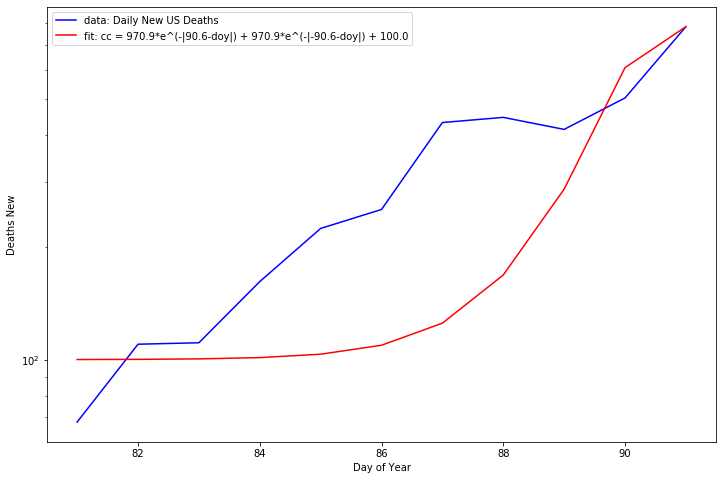

In [129]:

if first_time:
    first_time = False
else:
    p0a = popt[0]
    lba, uba = get_lb_ub(p0a)
    p0b = popt[1]
    lbb, ubb = get_lb_ub(p0b)
    p0c = popt[2]
    lbc, ubc = get_lb_ub(p0c)
popt, doubling_days, get_results = fit_spike_curve(column_name,
                                                   lba=lba, lbb=lbb, lbc=lbc,
                                                   uba=uba, ubb=ubb, ubc=ubc,
                                                   p0a=p0a, p0b=p0b, p0c=p0c,
                                                   min_x=60)

In [124]:

print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))
print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))
print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))


lba = 427.01555905769817
uba = 42701.55590576982
p0a = 4270.155590576982

lbb = 88.06176964098815
ubb = 8806.176964098815
p0b = 880.6176964098814

lbc = 31.91818181788667
ubc = 3191.818181788667
p0c = 319.1818181788667


In [17]:

from datetime import datetime

date_obj = datetime(year=2020, month=3, day=28)
dayofyear = pd.Timestamp(date_obj).dayofyear
new_deaths = int(get_results(dayofyear))
print('The US will have {:,} new deaths on {}.'.format(new_deaths, date_obj.strftime('%b %d, %Y')))

The US will have 107 new deaths on Mar 28, 2020.



## New Confirmations Spike Curve

In [109]:

max_new = tracking_df.Confirmed_New.max()
lba = max_new/10
uba = max_new*10
p0a = max_new

doy = tracking_df.Confirmed_New.idxmax().dayofyear
lbb = doy/10
ubb = doy*10
p0b = doy

min_new = tracking_df.Confirmed_New.min()
lbc = min_new/10
ubc = min_new*10
p0c = min_new

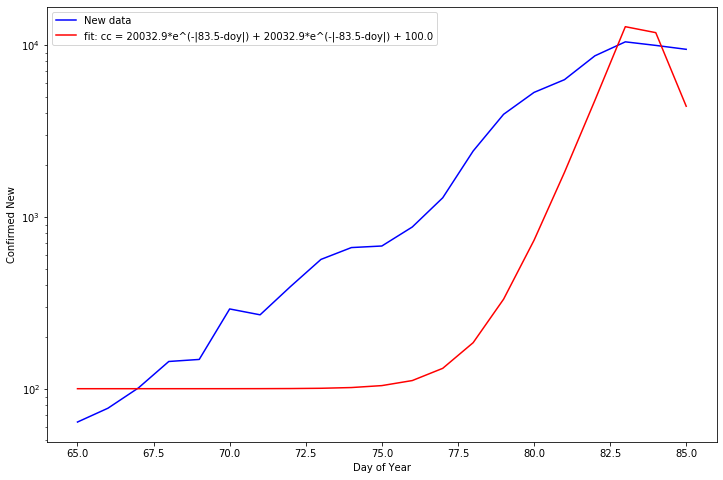

In [111]:

column_name = 'Confirmed_New'
p0a = popt[0]
lba, uba = get_lb_ub(p0a)
p0b = popt[1]
lbb, ubb = get_lb_ub(p0b)
p0c = popt[2]
lbc, ubc = get_lb_ub(p0c)
popt, doubling_days, get_results = fit_spike_curve(column_name,
                                                   lba=lba, lbb=lbb, lbc=lbc,
                                                   uba=uba, ubb=ubb, ubc=ubc,
                                                   p0a=p0a, p0b=p0b, p0c=p0c,
                                                   min_x=60)

In [114]:

from datetime import datetime

date_obj = datetime(year=2020, month=3, day=28)
dayofyear = pd.Timestamp(date_obj).dayofyear
new_deaths = int(get_results(dayofyear))
print('The US will have {:,} new confirmations on {}.'.format(new_deaths, date_obj.strftime('%b %d, %Y')))

The US will have 313 new deaths on Mar 28, 2020.


In [113]:

print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))
print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))
print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))


lba = 2022.3460486681902
uba = 202234.60486681902
p0a = 20223.460486681903

lbb = 8.345951439695229
ubb = 834.5951439695228
p0b = 83.45951439695229

lbc = 0.9999999999999998
ubc = 99.99999999999999
p0c = 9.999999999999998



---
## Power Curves

In [350]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

method = ['lm', 'trf', 'dogbox'][1]
def fit_pow_curve(column_name='Deaths_Cumulative',
                  lba=1e-09, lbb=-49, lbc=3.8, lbd=3.8,
                  uba=0.1, ubb=-41, ubc=8.3, ubd=8.3,
                  p0a=0.05, p0b=-46, p0c=3.9, p0d=3.9,
                  min_x=1, after_day=1):
    
    # Format the data
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    date_obj = datetime(year=2020, month=3, day=after_day)
    mask_series = (tracking_df.index >= pd.Timestamp(date_obj)) & (tracking_df[column_name] >= min_x)
    df = tracking_df[mask_series][columns_list].dropna(axis='index', how='any')
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def func(x, a, b, c, d):

        return a * pow(x + b, c) + d
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc, lbd],
                    [uba, ubb, ubc, ubd])
    p0_array = np.array([p0a, p0b, p0c, p0d])
    popt, pcov = curve_fit(func, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Plot the cumulative data
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, autoscale_on=True)
    ax.set_yscale('log')
    country_name = column_name.split('_')[-1]
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))
    
    # Plot the fitted curve
    def get_cumulative_confirmations(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #print('{} * pow({} + {}, {}) + {}'.format(popt[0], dayofyear, popt[1], popt[2], popt[3]))
        
        return popt[0] * pow(dayofyear + popt[1], popt[2]) + popt[3]
    label_str = 'fit: cc = %3.1f * pow(doy + %3.1f, %3.1f) + %3.1f' % tuple(popt)
    line_2d_obj = plt.plot(dayofyear_data, get_cumulative_confirmations(dayofyear_data), 'r-', label=label_str)
    
    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{} {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()
    
    # Get the doubling time
    average_doubling_time = get_average_doubling(confirmation_data)
    
    return popt, average_doubling_time, get_cumulative_confirmations


---
## Cumulative Deaths Power Curve

In [122]:

max_cumulative = tracking_df.Confirmed_Cumulative.max()
lba = max_cumulative/10
uba = max_cumulative*10
p0a = max_cumulative

doy = tracking_df.Confirmed_Cumulative.idxmax().dayofyear
lbb = doy/10
ubb = doy*10
p0b = doy

min_cumulative = tracking_df.Confirmed_Cumulative.min()
lbc = min_cumulative/10
ubc = min_cumulative*10
p0c = min_cumulative

In [343]:

lba = 3.2623737008620897e-08
uba = 3.26237370086209e-06
p0a = 3.26237370086209e-07

lbb = -532.9143272056222
ubb = -5.329143272056222
p0b = -53.29143272056222

lbc = 0.7526876544866821
ubc = 75.2687654486682
p0c = 7.526876544866821

lbd = -96.86648822354888
ubd = -0.9686648822354889
p0d = -9.686648822354888

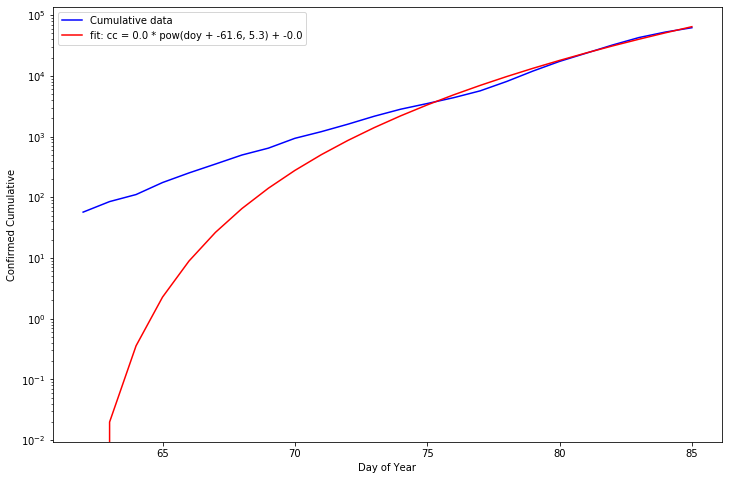

In [351]:

column_name = 'Confirmed_Cumulative'
p0a = popt[0]
lba, uba = get_lb_ub(p0a)
p0b = popt[1]
lbb, ubb = get_lb_ub(p0b)
p0c = popt[2]
lbc, ubc = get_lb_ub(p0c)
p0d = popt[3]
lbd, ubd = get_lb_ub(p0d)
try:
    popt, doubling_days, get_results = fit_pow_curve(column_name, lba=lba, lbb=lbb, lbc=lbc, lbd=lbd,
                                                     uba=uba, ubb=ubb, ubc=ubc, ubd=ubd,
                                                     p0a=p0a, p0b=p0b, p0c=p0c, p0d=p0d, min_x=50)
except Exception as e:
    message = str(e).strip()
    print(message)

In [345]:

from datetime import datetime

date_obj = datetime(year=2020, month=3, day=28)
dayofyear = pd.Timestamp(date_obj).dayofyear
new_deaths = int(get_results(dayofyear))
print('The US will have {:,} cumulative confirmations on {}.'.format(new_deaths, date_obj.strftime('%b %d, %Y')))

The US will have 127,217 cumulative confirmations on Mar 28, 2020.


In [339]:

print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))
print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))
print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))
print('''
lbd = {}
ubd = {}
p0d = {}'''.format(lbd, ubd, p0d))


lba = 3.2623737008620897e-08
uba = 3.26237370086209e-06
p0a = 3.26237370086209e-07

lbb = -532.9143272056222
ubb = -5.329143272056222
p0b = -53.29143272056222

lbc = 0.7526876544866821
ubc = 75.2687654486682
p0c = 7.526876544866821

lbd = -96.86648822354888
ubd = -0.9686648822354889
p0d = -9.686648822354888



---

In [10]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

method = ['lm', 'trf', 'dogbox'][1]
def fit_curve(column_name='Deaths_Cumulative',
              lba=1e-09, lbb=-49, lbc=3.8, lbd=-1.0, lbe=-1.0,
              uba=0.1, ubb=-41, ubc=8.3, ubd=1.0, ube=1.0,
              p0a=0.05, p0b=-46, p0c=3.9, p0d=0.0, p0e=0.0,
              min_x=1):
    
    # Format the data
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    mask_series = (tracking_df[column_name] >= min_x)
    df = tracking_df[mask_series][columns_list].dropna(axis='index', how='any')
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def func(x, a, b, c, d, e):

        return a * pow(x + b, c) + d * x + e
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc, lbd, lbe],
                    [uba, ubb, ubc, ubd, ube])
    p0_array = np.array([p0a, p0b, p0c, p0d, p0e])
    popt, pcov = curve_fit(func, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Plot the cumulative data
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    country_name = column_name.split('_')[-1]
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))
    
    # Plot the fitted curve
    def get_cumulative_confirmations(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #print('{} * pow({} + {}, {}) + {} * {} + {}'.format(popt[0], dayofyear, popt[1], popt[2], popt[3], dayofyear, popt[4]))
        
        return popt[0] * pow(dayofyear + popt[1], popt[2]) + popt[3] * dayofyear + popt[4]
    label_str = 'fit: cc = %3.2f * pow(doy%3.0f, %3.1f) + %3.1f * doy + %3.1f' % tuple(popt)
    line_2d_obj = plt.plot(dayofyear_data, get_cumulative_confirmations(dayofyear_data), 'r-', label=label_str)
    
    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{} {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()
    
    # Get the doubling time
    doubling_time_list = []
    for i, confirms in enumerate(confirmation_data):
        if i > 0:
            doubling_time = get_doubling_days(confirmation_data[i-1], confirmation_data[i])
            doubling_time_list.append(doubling_time)
    average_doubling_time = np.array(doubling_time_list).mean()
    
    return popt, average_doubling_time, get_cumulative_confirmations

The US will have 1,310 cumulative deaths today. It is doubling every 3.8 days.
That 1.0000000000000003e-09 * pow(dayofyear-48, 7.671722341113232) + -0.08941274015985463 * dayofyear + 0.9999999999999999 curve shown in red is fitted to the data.


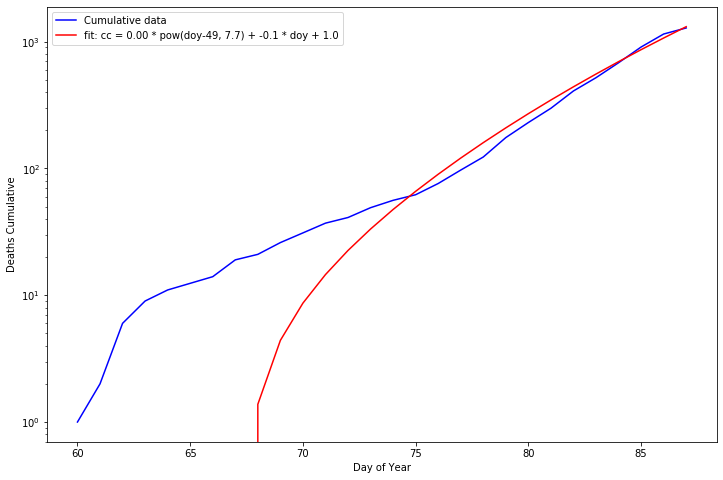

In [12]:

popt, doubling_days, get_cumulative_deaths = fit_curve('Deaths_Cumulative')
dayofyear = pd.Timestamp(datetime.now()).dayofyear
#print(dayofyear)
confirmed_now = int(get_cumulative_deaths(dayofyear))
print('The US will have {:,} cumulative deaths today. It is doubling every {} days.'.format(confirmed_now, round(doubling_days, 1)))
formatted_str = 'That {} * pow(dayofyear{}, {}) + {} * dayofyear + {} curve shown in red is fitted to the data.'
print(formatted_str.format(popt[0], int(popt[1]), popt[2], popt[3], popt[4]))

In [ ]:

# Hall of Fame
lba = 4.110281698247205e-31
uba = 4.110281698247205e-29
p0a = 4.110281698247205e-30

lbb = -513.9398352299962
ubb = -5.139398352299962
p0b = -51.39398352299962

lbc = 2.2185491179655665
ubc = 221.85491179655662
p0c = 22.185491179655664

lbd = 0.3701748485216486
ubd = 37.017484852164856
p0d = 3.701748485216486

lbe = -2165.504631099008
ube = -21.65504631099008
p0e = -216.5504631099008

In [110]:

method = ['lm', 'trf', 'dogbox'][1]
def fit_curve_sans_graph(column_name='Deaths_Cumulative',
                         lba=1e-09, lbb=-49, lbc=3.8, lbd=-1.0, lbe=-1.0,
                         uba=0.1, ubb=-41, ubc=8.3, ubd=1.0, ube=1.0,
                         p0a=0.05, p0b=-46, p0c=3.9, p0d=0.0, p0e=0.0,
                         min_x=1):
    
    # Format the data
    df = format_the_data(column_name)
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def func(x, a, b, c, d, e):

        return a * pow(x + b, c) + d * x + e
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc, lbd, lbe],
                    [uba, ubb, ubc, ubd, ube])
    p0_array = np.array([p0a, p0b, p0c, p0d, p0e])
    popt, pcov = curve_fit(func, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Don't plot the fitted curve
    def get_cumulative_confirmations(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #print('{} * pow({} + {}, {}) + {} * {} + {}'.format(popt[0], dayofyear, popt[1], popt[2], popt[3], dayofyear, popt[4]))
        
        return popt[0] * pow(dayofyear + popt[1], popt[2]) + popt[3] * dayofyear + popt[4]
    
    # Get the doubling time
    average_doubling_time = get_average_doubling(confirmation_data)
    
    return popt, average_doubling_time, get_cumulative_confirmations

In [79]:

def overfit_curve(popt, doubling_days=None, get_results=None, column_name='Deaths_Cumulative'):
    p0a = popt[0]
    lba, uba = get_lb_ub(p0a)
    p0b = popt[1]
    lbb, ubb = get_lb_ub(p0b)
    p0c = popt[2]
    lbc, ubc = get_lb_ub(p0c)
    p0d = popt[3]
    lbd, ubd = get_lb_ub(p0d)
    p0e = popt[4]
    lbe, ube = get_lb_ub(p0e)
    try:
        popt, doubling_days, get_results = fit_curve_sans_graph(column_name,
                                                                lba=lba, lbb=lbb, lbc=lbc, lbd=lbd, lbe=lbe,
                                                                uba=uba, ubb=ubb, ubc=ubc, ubd=ubd, ube=ube,
                                                                p0a=p0a, p0b=p0b, p0c=p0c, p0d=p0d, p0e=p0e,
                                                                min_x=60)
    except ValueError as e:
        message = str(e).strip()
        print(message)
        print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))
        print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))
        print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))
        print('''
lbd = {}
ubd = {}
p0d = {}'''.format(lbd, ubd, p0d))
        print('''
lbe = {}
ube = {}
p0e = {}'''.format(lbe, ube, p0e))
    
    return popt, doubling_days, get_results

In [90]:

for i in range(10):
    popt, doubling_days, get_results = overfit_curve(popt, doubling_days, get_results, column_name='Deaths_Cumulative')

array must not contain infs or NaNs

lba = 0.12309943329721984
uba = 12.309943329721984
p0a = 1.2309943329721984

lbb = -738.6649714789803
ubb = -7.386649714789803
p0b = -73.86649714789803

lbc = 0.26901478172140514
ubc = 26.901478172140514
p0c = 2.6901478172140516

lbd = 0.08402165631346971
ubd = 8.402165631346971
p0d = 0.8402165631346971

lbe = -3.3265129610783047e-13
ube = -3.3265129610783046e-15
p0e = -3.3265129610783047e-14


In [91]:

p0a = popt[0]
lba, uba = get_lb_ub(p0a)
p0b = popt[1]
lbb, ubb = get_lb_ub(p0b)
p0c = popt[2]
lbc, ubc = get_lb_ub(p0c)
p0d = popt[3]
lbd, ubd = get_lb_ub(p0d)
p0e = popt[4]
lbe, ube = get_lb_ub(p0e)
popt, doubling_days, get_cumulative_deaths = fit_curve('Deaths_Cumulative',
                                                       lba=lba, lbb=lbb, lbc=lbc, lbd=lbd, lbe=lbe,
                                                       uba=uba, ubb=ubb, ubc=ubc, ubd=ubd, ube=ube,
                                                       p0a=p0a, p0b=p0b, p0c=p0c, p0d=p0d, p0e=p0e,
                                                       min_x=1)
dayofyear = pd.Timestamp(datetime.now()).dayofyear
#dayofyear = pd.Timestamp(datetime(year=2020, month=3, day=16)).dayofyear
confirmed_now = int(get_cumulative_deaths(dayofyear))
print('The US will have {:,} cumulative confirmed cases today. It is doubling every {} days.'.format(confirmed_now, round(doubling_days, 1)))
formatted_str = 'That {} * pow(dayofyear{}, {}) + {} * dayofyear + {} curve shown in red is (over)fitted to the data.'
print(formatted_str.format(popt[0], popt[1], popt[2], popt[3], popt[4]))

ValueError: Residuals are not finite in the initial point.

In [92]:

print(lba, popt[0], uba)
print(lbb, popt[1], ubb)
print(lbc, popt[2], ubc)
print(lbd, popt[3], ubd)
print(lbe, popt[4], ube)
dayofyear = pd.Timestamp(datetime.now()).dayofyear
confirmed_now = int(get_cumulative_deaths_usa(dayofyear))
print('The US will have {:,} cumulative confirmed deaths today. It is doubling every {} days.'.format(confirmed_now, round(doubling_days, 1)))
formatted_str = 'That {} * pow(dayofyear{}, {}) + {} * dayofyear + {} curve shown in red is (over)fitted to the data.'
print(formatted_str.format(popt[0], popt[1], popt[2], popt[3], popt[4]))

0.12309943329721984 1.2309943329721984 12.309943329721984
-738.6649714789803 -73.86649714789803 -7.386649714789803
0.26901478172140514 2.6901478172140516 26.901478172140514
0.08402165631346971 0.8402165631346971 8.402165631346971
-3.3265129610783047e-13 -3.3265129610783047e-14 -3.3265129610783046e-15
The US will have 1,340 cumulative confirmed deaths today. It is doubling every 3.3 days.
That 1.2309943329721984 * pow(dayofyear-73.86649714789803, 2.6901478172140516) + 0.8402165631346971 * dayofyear + -3.3265129610783047e-14 curve shown in red is (over)fitted to the data.


In [ ]:

tracking_df.columns

In [ ]:

def get_lb_ub(p0):
    if p0 < 0:
        uba = math.copysign(abs(p0)/10, p0)
        lba = math.copysign(abs(p0)*10, p0)
    else:
        lba = math.copysign(abs(p0)/10, p0)
        uba = math.copysign(abs(p0)*10, p0)
    
    return lba, uba

p0a = popt[0]
lba, uba = get_lb_ub(p0a)
print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))

p0b = popt[1]
lbb, ubb = get_lb_ub(p0b)
print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))

p0c = popt[2]
lbc, ubc = get_lb_ub(p0c)
print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))

p0d = popt[3]
lbd, ubd = get_lb_ub(p0d)
print('''
lbd = {}
ubd = {}
p0d = {}'''.format(lbd, ubd, p0d))

p0e = popt[4]
lbe, ube = get_lb_ub(p0e)
print('''
lbe = {}
ube = {}
p0e = {}'''.format(lbe, ube, p0e))

In [ ]:

lba = 3.5898673196110995e-29
uba = 3.589867319611099e-27
p0a = 3.5898673196110993e-28

lbb = -258.0043216718908
ubb = -2.580043216718908
p0b = -25.80043216718908

lbc = 1.794478077861036
ubc = 179.44780778610362
p0c = 17.94478077861036

lbd = 4.482007640229286
ubd = 448.2007640229285
p0d = 44.820076402292855

lbe = -32017.1490577167
ube = -320.171490577167
p0e = -3201.7149057716697

In [ ]:

column_name = 'Confirmed_New_usa'
popt, doubling_days, get_new_confirmations_usa = fit_curve(column_name=column_name,
                                                           lba=lba, lbb=lbb, lbc=lbc, lbd=lbd, lbe=lbe,
                                                           uba=uba, ubb=ubb, ubc=ubc, ubd=ubd, ube=ube,
                                                           p0a=p0a, p0b=p0b, p0c=p0c, p0d=p0d, p0e=p0e,
                                                           min_x=100)
dayofyear = pd.Timestamp(datetime.now()).dayofyear
confirmed_now = int(get_new_confirmations_usa(dayofyear))
word_list = column_name.lower().split('_')
formatted_str = 'The US will have {:,} {} {} cases today. It is doubling every {} days.'
print(formatted_str.format(confirmed_now, word_list[0], word_list[1], round(doubling_days, 1)))
formatted_str = 'That {} * pow(dayofyear{}, {}) + {} * dayofyear + {} curve shown in red is (over)fitted to the data.'
print(formatted_str.format(popt[0], popt[1], popt[2], popt[3], popt[4]))

In [ ]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

#tracking_df = s.load_object('tracking_df')
method = ['lm', 'trf', 'dogbox'][1]
def fit_sigmoid_curve(column_name='Confirmed_New_usa',
                      lba=1e-09, lbb=-49, lbc=3.8,
                      uba=0.1, ubb=-41, ubc=8.3,
                      p0a=0.05, p0b=-46, p0c=3.9,
                      min_x=100):
    
    # Format the data
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    mask_series = (tracking_df[column_name] >= min_x)
    df = tracking_df[mask_series][columns_list].dropna(axis='index', how='any')
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def sigmoid(x, a, b, c):
        #print('{} / (1 + np.exp(-1*{}*np.subtract(np.array({}), {})))'.format(a, b, x, c))
        
        return a / (1 + np.exp(-1*b*np.subtract(x, c)))
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc],
                    [uba, ubb, ubc])
    p0_array = np.array([p0a, p0b, p0c])
    popt, pcov = curve_fit(sigmoid, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Plot the cumulative data
    fig = plt.figure(figsize=(18, 4))
    ax = fig.add_subplot(111)
    #ax.set_yscale('log')
    country_name = column_name.split('_')[-1]
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))
    
    # Plot the fitted curve
    def get_cumulative_confirmations(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #print('{} / (1 + np.exp(-{}({}-{})))'.format(popt[0], popt[1], dayofyear, popt[2]))
        
        return popt[0] / (1 + np.exp(-1*popt[1]*np.subtract(dayofyear, popt[2])))
    label_str = 'fit: cc = %3.0f / (1 + np.exp(-%3.1f(doy-%3.1f)))' % tuple(popt)
    line_2d_obj = plt.plot(dayofyear_data, get_cumulative_confirmations(dayofyear_data), 'r-', label=label_str)
    
    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{} {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()
    
    # Get the doubling time
    doubling_time_list = []
    for i, confirms in enumerate(confirmation_data):
        if i > 0:
            growth_rate = (confirmation_data[i]-confirmation_data[i-1])/confirmation_data[i]
            doubling_time = math.log(2)/growth_rate
            if (doubling_time != np.inf) and (doubling_time > 0):
                doubling_time_list.append(doubling_time)
    average_doubling_time = np.array(doubling_time_list).mean()
    
    return popt, average_doubling_time, get_cumulative_confirmations

In [ ]:

column_name = 'Confirmed_New_usa'
popt, doubling_days, get_new_confirmations_usa = fit_sigmoid_curve(column_name=column_name, lba=lba, lbb=lbb, lbc=lbc, uba=uba, ubb=ubb, ubc=ubc,
                                                                   p0a=p0a, p0b=p0b, p0c=p0c, min_x=1)

In [ ]:

p0a = popt[0]
lba, uba = get_lb_ub(p0a)
print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))

p0b = popt[1]
lbb, ubb = get_lb_ub(p0b)
print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))

p0c = popt[2]
lbc, ubc = get_lb_ub(p0c)
print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))

In [ ]:

column_name = 'Deaths_New_usa'
popt, doubling_days, get_new_deaths_usa = fit_sigmoid_curve(column_name=column_name, lba=lba, lbb=lbb, lbc=lbc, uba=uba, ubb=ubb,
                                                            ubc=ubc, p0a=p0a, p0b=p0b, p0c=p0c, min_x=1)

In [ ]:

#date_obj = datetime(year=2020, month=12, day=31)
#dayofyear = pd.Timestamp(date_obj).dayofyear
date_obj = datetime.now()
dayofyear = pd.Timestamp(date_obj).dayofyear
confirmed_now = int(get_new_deaths_usa(dayofyear))
word_list = column_name.lower().split('_')
formatted_str = 'The US will have {:,} {} {} on {}. It is doubling every {} days.'
print(formatted_str.format(confirmed_now, word_list[0], word_list[1], date_obj.strftime('%b %d, %Y'), round(doubling_days, 1)))
formatted_str = 'That {} / (1 + math.exp(-1*{}*(dayofyear-{}))) curve shown in red is (over)fitted to the data.'
print(formatted_str.format(popt[0], popt[1], popt[2]))

In [ ]:

lba = 6166330.3878130205
uba = 616633038.7813021/4
p0a = 61663303.878130205

lbb = 0.039285826964592
ubb = 3.9285826964591997
p0b = 0.39285826964591997

lbc = 10.381717623034424
ubc = 1038.1717623034424
p0c = 103.81717623034424